In [1]:
#!pip install surprise

import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from csv import reader
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")


/home/priyam/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading the data

In [2]:
# Skip date
df1 = pd.read_csv('../movie_data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


As seen above, we have 3 columns here.
1. Movie ID (a unqiue identifier for each movie)
2. Customer ID (a unqiue identifier for each customer)
3. Ratings given by the customers.

In [3]:
#Taking just one sample for the first iteration, more data resulting in slower computation

#df2 = pd.read_csv('../movie_data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df3 = pd.read_csv('../movie_data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df4 = pd.read_csv('../movie_data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


#df2['Rating'] = df2['Rating'].astype(float)
#df3['Rating'] = df3['Rating'].astype(float)
#df4['Rating'] = df4['Rating'].astype(float)

#print('Dataset 2 shape: {}'.format(df2.shape))
#print('Dataset 3 shape: {}'.format(df3.shape))
#print('Dataset 4 shape: {}'.format(df4.shape))

In [4]:
#print('-Dataset examples-')
#print(df4.iloc[::5000000, :])

We checked, the remaining files contains the same features as the first file.
The data is divided into 3 files for manageability.

In [5]:
# Combining the datasets
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

#Taking just one sample for the first iteration, more data resulting in slower computation
df = df1

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


## Data Visualization

Looking at the data spread

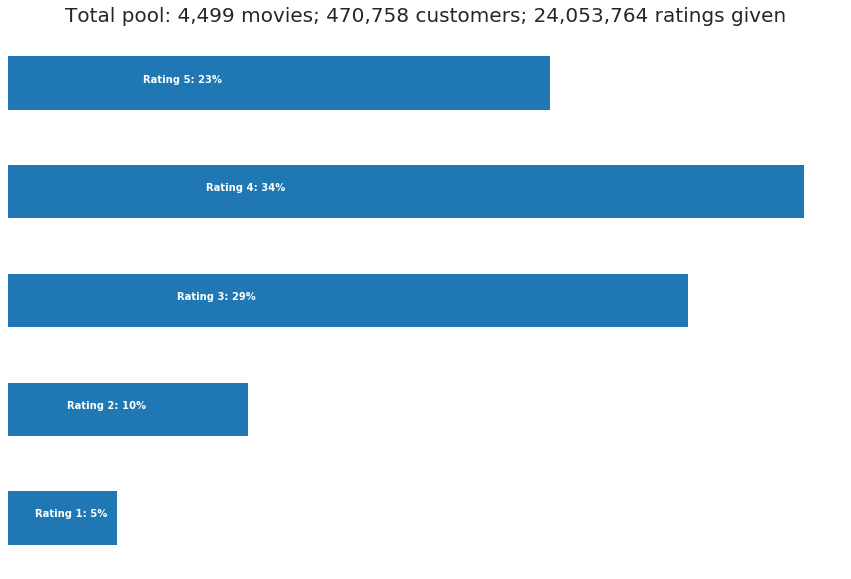

In [6]:
# Movie count
movie_count = df.isnull().sum()[1]

# Customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# Ratings count
rating_count = df['Cust_Id'].count() - movie_count

p = df.groupby('Rating')['Rating'].agg(['count'])
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} movies; {:,} customers; {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

### Observation

From the above histogram we can observe that, the ratings are generally postive with most of the items with having ratings equal or more than 3.

We could attribute this penomenon to the the user's disengagement with the platform if they don't like the content, they would not even bother to rate it at all.
Hence, considering this in mind, a low rating  would mean the movies really left a very poor taste in user's mouth.

### Data Cleaning

In [7]:
# Retrieving the columns that have the ratings present
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

In [8]:
df_nan.info

<bound method DataFrame.info of          index  Rating
0            0    True
1          548    True
2          694    True
3         2707    True
4         2850    True
...        ...     ...
4494  24046714    True
4495  24047329    True
4496  24056849    True
4497  24057564    True
4498  24057834    True

[4499 rows x 2 columns]>

In [9]:
# trying to add movie_id column to the dataframe

movie_np = []
movie_id = 1

for i, j in zip(df_nan['index'][1:], df_nan['index'][:-1]):
    tmp = np.full((1, i-j-1), movie_id)
    movie_np = np.append(movie_np, tmp)
    movie_id += 1
    
# Checking for last record
last_record = np.full((1,len(df) - df_nan.iloc[-1,0] - 1), movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))


Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [10]:
df_nan['index']

0              0
1            548
2            694
3           2707
4           2850
          ...   
4494    24046714
4495    24047329
4496    24056849
4497    24057564
4498    24057834
Name: index, Length: 4499, dtype: int64

In [11]:
#Removing movie_id row
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)

print("Dataset Example")
print(df.iloc[::5000000, :])

/home/priyam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Dataset Example
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


/home/priyam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### Removing less relevant movies and users
1. Removing the movie with very less reviews, we could state these movies are not very popular.
2. Removing the customers who gave very less reviews


This should help with removing dead weigght from the dataset and improve the statisctical significance too.

In [12]:
#Movie based

f = ['count', 'mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Minimum number of reviews(per movie): {}'.format(movie_benchmark))

Minimum number of reviews(per movie): 1799.0


In [13]:
# Customer based

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7), 0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Minimun number of reviews(per customer): {}'.format(cust_benchmark))

Minimun number of reviews(per customer): 52.0


In [14]:
# Trimming down the dataset

print('Original Shape: {}'. format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]

print('Shape post trim: {}'.format(df.shape))

print('Data Example')
print(df.iloc[::5000000,:])

Original Shape: (24053764, 3)
Shape post trim: (17337458, 3)
Data Example
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


In [15]:
#pivoting the dataset into a matrix

df_p = pd.pivot_table(df, values='Rating', index='Cust_Id', columns='Movie_Id')
print(df_p.shape)

(143458, 1350)


In [16]:
df_p

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649378,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN


In [17]:
#Loading the movie mapping file

df_title = pd.read_csv('../movie_data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace=True)
print(df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


#### Recommendation with Collaborative Filtering

In [19]:
reader = Reader()

# Dealing with just 100k rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])


{'test_rmse': array([0.84818086, 0.8485656 , 0.84816333, 0.84790502, 0.84833019]),
 'test_mae': array([0.65867034, 0.65885476, 0.65865745, 0.65814838, 0.65820733]),
 'fit_time': (719.3063323497772,
  672.6736781597137,
  672.3219938278198,
  676.55699634552,
  715.0812113285065),
 'test_time': (108.89333057403564,
  67.29921174049377,
  95.99775576591492,
  94.7617301940918,
  70.89969658851624)}

### Model Validation

Checking the current info for user 783514, i.e. what all movies this user liked in the past.

In [20]:
# Checking the current info for a randon user 
# user 783514 and rating 5

df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

### Testing the prediction algorithm

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
...,...,...
17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17767,2004.0,Fidel Castro: American Experience
17768,2000.0,Epoch


In [27]:
#Getting the user specific info
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

#Loading the full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)


In [28]:
#Estimating the score for the user
user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)
user_785314 = user_785314.drop('Movie_Id', axis = 1)
user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

        Year                                               Name  \
2860  1996.0                                Babylon 5: Season 4   
2558  1993.0  Mystery Science Theater 3000: The Wild World o...   
3149  2000.0                   Monty Python: The Life of Python   
1551  1983.0                                        Black Adder   
3768  2004.0                   Wonderfalls: The Complete Series   
3167  1987.0                          Evil Dead 2: Dead by Dawn   
2018  2004.0                                   Samurai Champloo   
2171  1991.0                             The Simpsons: Season 3   
4391  1993.0                                   Army of Darkness   
2802  1995.0                                Pride and Prejudice   

      Estimate_Score  
2860        5.000000  
2558        4.979183  
3149        4.914790  
1551        4.862728  
3768        4.856629  
3167        4.824661  
2018        4.817389  
2171        4.778910  
4391        4.778079  
2802        4.754023  
